<a href="https://colab.research.google.com/github/hanmrf/MachineLearning/blob/main/grape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1

In [ ]:
# Impor library yang dibutuhkan
from IPython import get_ipython
from IPython.display import display
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageDraw, ImageOps # Impor Image dan ImageDraw dari PIL

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download muhammadraihanf12/agrocurify-grape

Dataset URL: https://www.kaggle.com/datasets/muhammadraihanf12/agrocurify-grape
License(s): unknown
 92% 129M/140M [00:01<00:00, 123MB/s]
100% 140M/140M [00:01<00:00, 105MB/s]


In [ ]:
import zipfile

# Lokasi file ZIP
zip_file_path = "/content/agrocurify-grape.zip"
extract_to_path = "/content/"

# Mengekstrak file ZIP
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
        print("File berhasil diekstrak ke direktori:", extract_to_path)
else:
    print("File ZIP tidak ditemukan di lokasi:", zip_file_path)

File berhasil diekstrak ke direktori: /content/


In [ ]:
grape_data = "/content/anggur"
grape_classes = os.listdir(grape_data)

print("grape_classes:")
for classes in grape_classes:
    if os.path.isdir(os.path.join(grape_data, classes)):
        print(classes)

grape_classes:
Grape___Esca_(Black_Measles)
Grape___healthy
not_anggur
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___Black_rot



Class Name: Grape___Esca_(Black_Measles)
Total Images: 1920
Resolution of First Image: (256, 256, 3)


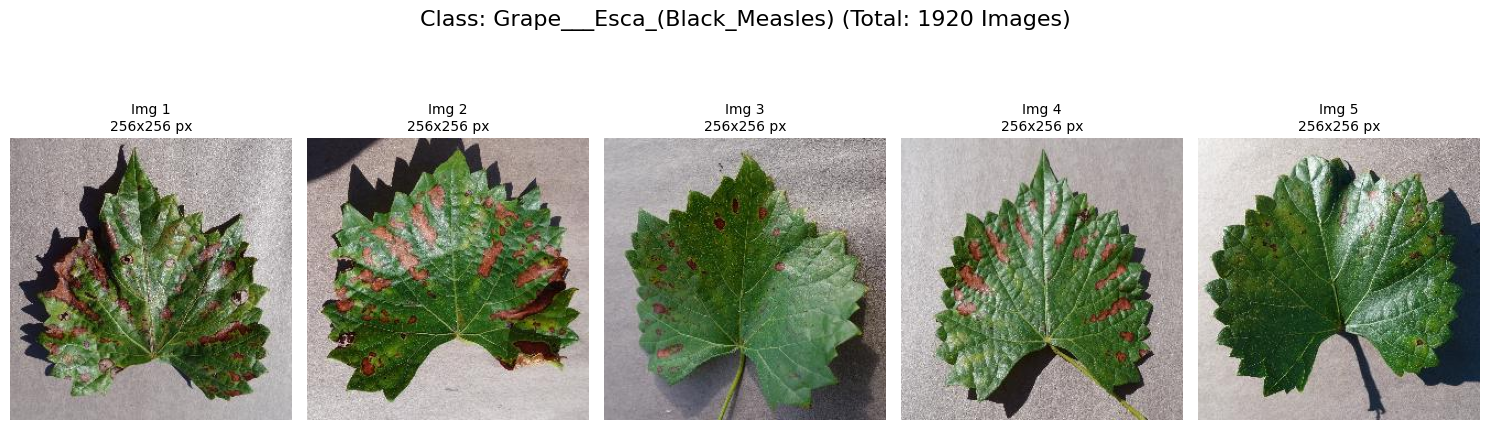


Class Name: Grape___healthy
Total Images: 1692
Resolution of First Image: (256, 256, 3)


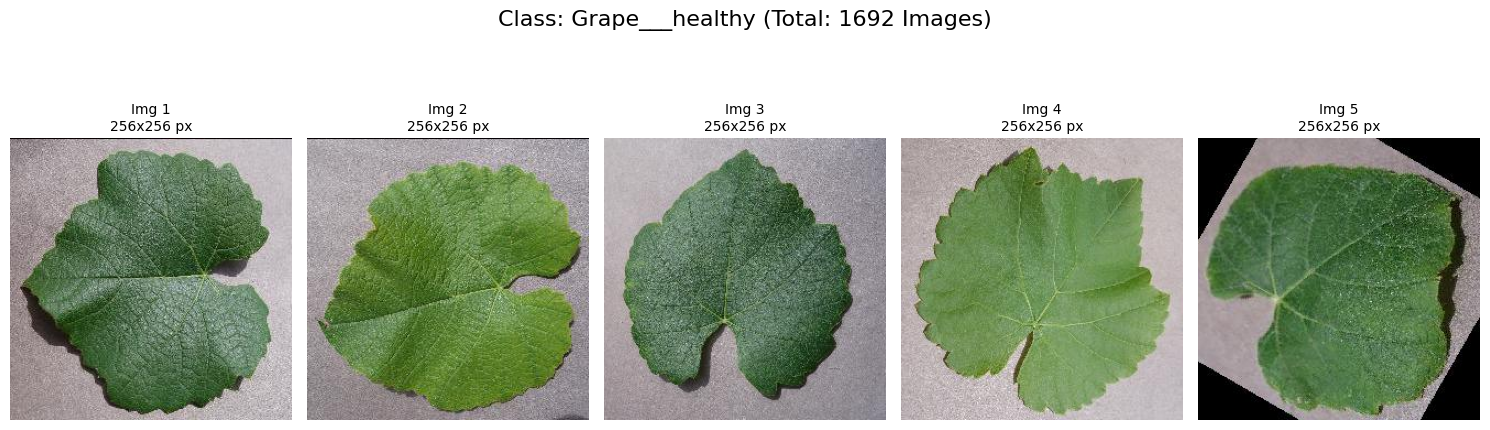


Class Name: not_anggur
Total Images: 1289
Resolution of First Image: (256, 384, 3)


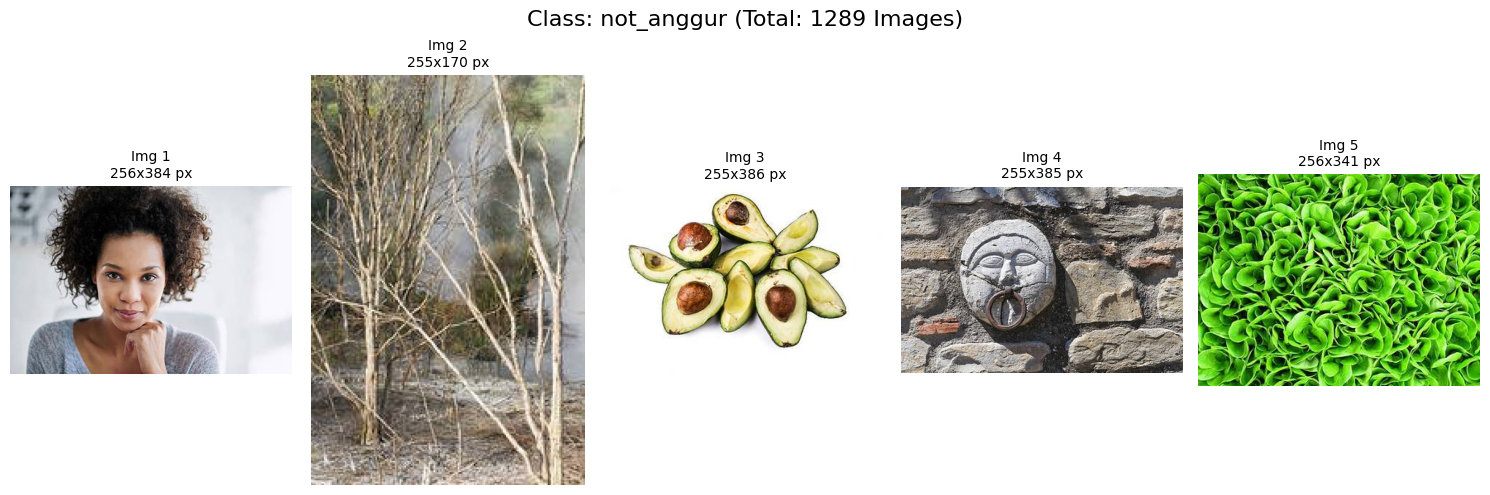


Class Name: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Total Images: 1722
Resolution of First Image: (256, 256, 3)


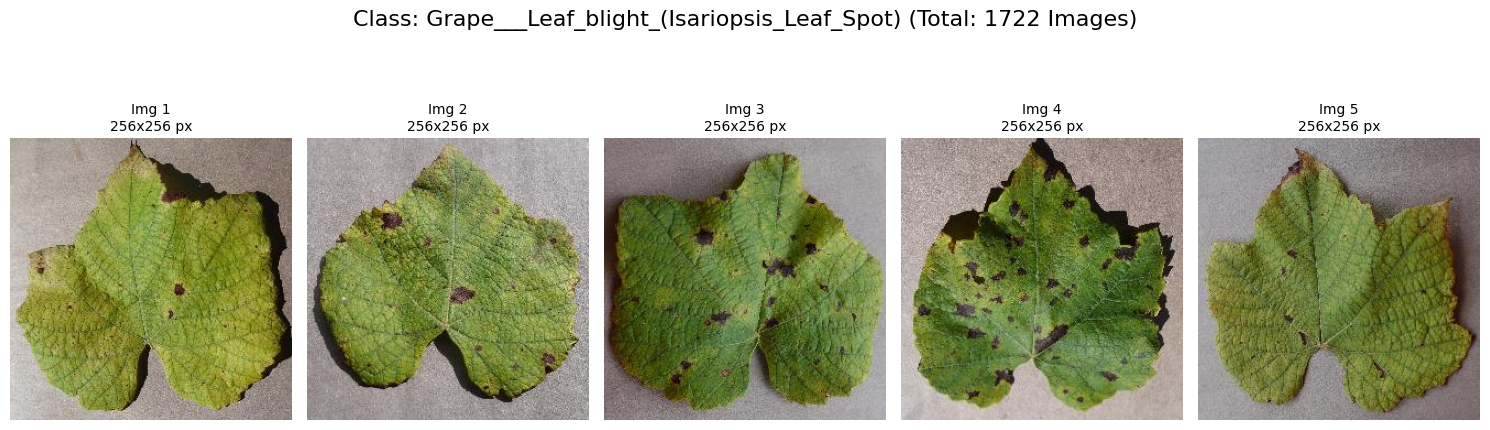


Class Name: Grape___Black_rot
Total Images: 1888
Resolution of First Image: (256, 256, 3)


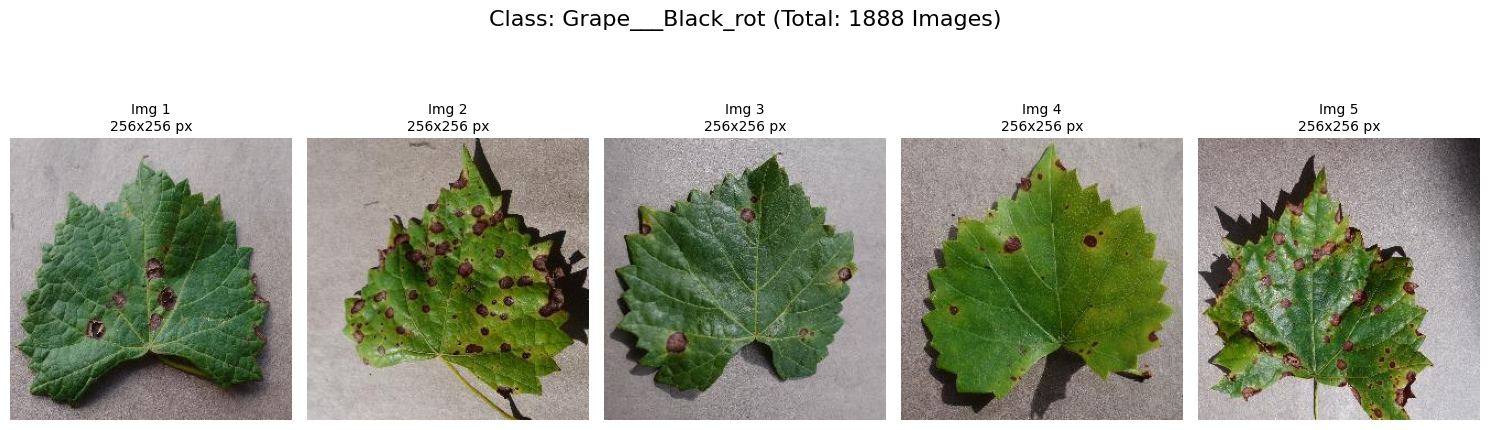

In [ ]:
for item in grape_classes:
    print("\nClass Name:", item)
    class_dir = os.path.join(grape_data, item)
    class_images = os.listdir(class_dir)

    # Total images in each class
    num_images = len(class_images)
    print("Total Images:", num_images)

    # Resolution/size of the first image in the class
    img_path = os.path.join(class_dir, class_images[0])
    img = mpimg.imread(img_path)
    image_shape = img.shape
    print("Resolution of First Image:", image_shape)

    # Displaying some images with descriptive labels
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Class: {item} (Total: {num_images} Images)", fontsize=16)

    for i, img_file in enumerate(class_images[:5]):  # Display up to 5 images
        img_path = os.path.join(class_dir, img_file)
        img = mpimg.imread(img_path)

        # Add a subplot for each image
        sp = plt.subplot(1, 5, i + 1)
        plt.axis('off')
        plt.imshow(img)

        # Add descriptive title to each image
        plt.title(f"Img {i+1}\n{img.shape[0]}x{img.shape[1]} px", fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust to fit the suptitle
    plt.show()

# Preprocesing Dataset

In [ ]:
# New Directory for Resized Dataset
resized_dir = "/content/resized"
os.makedirs(resized_dir, exist_ok=True)

# Pixel Normalization
def normalize_image(image):
    normalized_image = image.astype(np.float32) / 255.0
    return normalized_image

# Fungsi resize_with_aspect_ratio
def resize_with_aspect_ratio(image, target_size):
    image.thumbnail(target_size, Image.Resampling.LANCZOS)  # Ganti dengan Image.Resampling.LANCZOS

    # Membuat gambar baru dengan ukuran target dan menempelkan gambar yang sudah diubah ukurannya
    new_image = Image.new("RGB", target_size, (255, 255, 255))
    new_image.paste(image, ((target_size[0] - image.size[0]) // 2, (target_size[1] - image.size[1]) // 2))

    return new_image

    # Membuat gambar baru dengan ukuran target
    new_image = Image.new("RGB", target_size, (255, 255, 255))  # Gambar putih sebagai latar belakang
    new_image.paste(image, ((target_size[0] - image.size[0]) // 2, (target_size[1] - image.size[1]) // 2))
    return new_image

for item in grape_classes:
    class_dir = os.path.join(grape_data, item)
    class_images = os.listdir(class_dir)

    for img_path in class_images:
        img = Image.open(os.path.join(class_dir, img_path))
        resized_img = resize_with_aspect_ratio(img, (224, 224))
        normalized_img = normalize_image(np.array(resized_img))

        # Save Image to resized_dir
        save_path = os.path.join(resized_dir, item, img_path)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        Image.fromarray((normalized_img * 255).astype(np.uint8)).save(save_path)

In [ ]:
# New Directory for Balanced Dataset
balanced_dir = "/content/balanced"

# Number of Images to Be Selected from Each Class
num_images_per_class = min(len(os.listdir(resized_dir+"/Grape___Esca_(Black_Measles)")),
                           len(os.listdir(resized_dir+"/Grape___Black_rot")),
                           len(os.listdir(resized_dir+"/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)")),
                           len(os.listdir(resized_dir+"/Grape___healthy")),
                           len(os.listdir(resized_dir+"/not_anggur")))

# Create New Directory in balanced_dir
os.makedirs(balanced_dir+"/Grape___Esca_(Black_Measles)", exist_ok=True)
os.makedirs(balanced_dir+"/Grape___Black_rot", exist_ok=True)
os.makedirs(balanced_dir+"/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)", exist_ok=True)
os.makedirs(balanced_dir+"/Grape___healthy", exist_ok=True)
os.makedirs(balanced_dir+"/not_anggur", exist_ok=True)

# Select Some Images from Each Class and Copy to balanced_dir
selected_images = os.listdir(resized_dir+"/Grape___Esca_(Black_Measles)")[:num_images_per_class]
for image in selected_images:
    shutil.copy(os.path.join(resized_dir+"/Grape___Esca_(Black_Measles)", image), balanced_dir+"/Grape___Esca_(Black_Measles)")

selected_images = os.listdir(resized_dir+"/Grape___Black_rot")[:num_images_per_class]
for image in selected_images:
    shutil.copy(os.path.join(resized_dir+"/Grape___Black_rot", image), balanced_dir+"/Grape___Black_rot")

selected_images = os.listdir(resized_dir+"/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)")[:num_images_per_class]
for image in selected_images:
    shutil.copy(os.path.join(resized_dir+"/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)", image), balanced_dir+"/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)")

selected_images = os.listdir(resized_dir+"/Grape___healthy")[:num_images_per_class]
for image in selected_images:
    shutil.copy(os.path.join(resized_dir+"/Grape___healthy", image), balanced_dir+"/Grape___healthy")

selected_images = os.listdir(resized_dir+"/not_anggur")[:num_images_per_class]
for image in selected_images:
    shutil.copy(os.path.join(resized_dir+"/not_anggur", image), balanced_dir+"/not_anggur")

Preview Gambar dari Dataset yang Seimbang:

Kelas: Grape___Esca_(Black_Measles)
Total Gambar: 1289


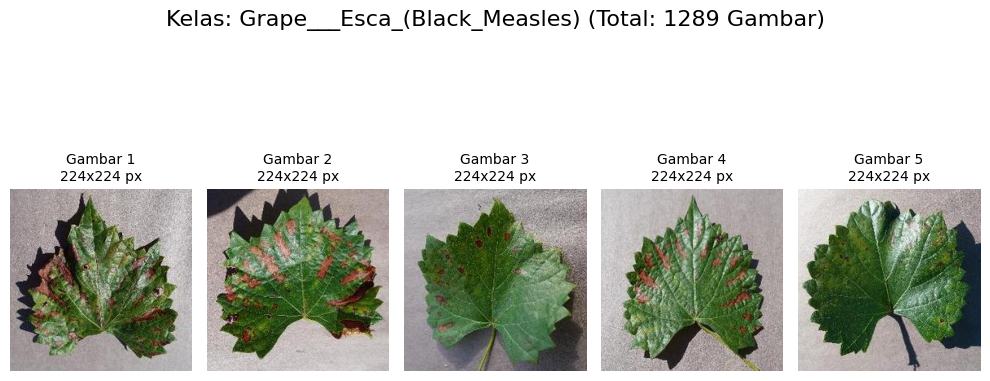


Kelas: Grape___healthy
Total Gambar: 1289


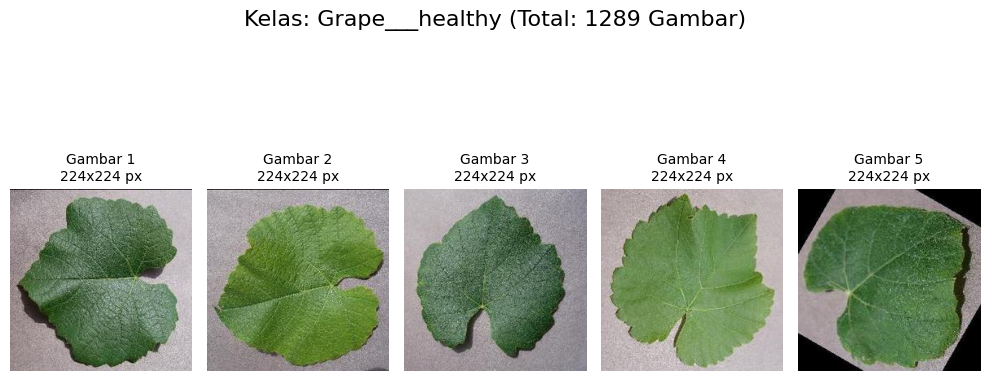


Kelas: not_anggur
Total Gambar: 1289


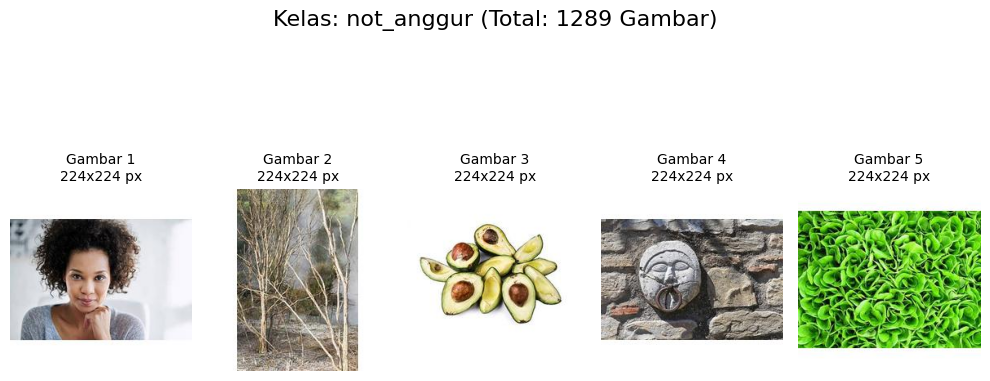


Kelas: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Total Gambar: 1289


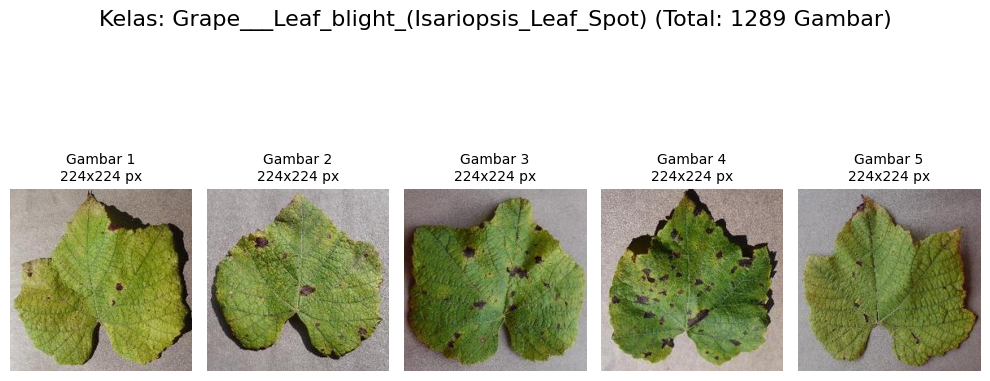


Kelas: Grape___Black_rot
Total Gambar: 1289


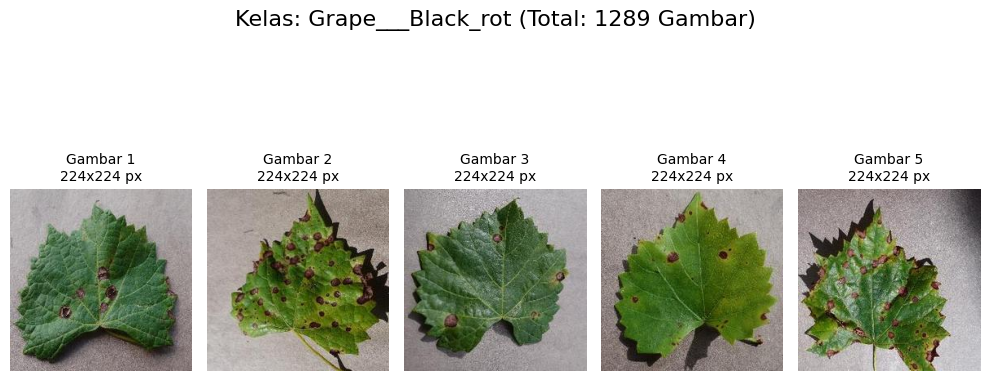

In [ ]:
# Preview Gambar dari Dataset yang Seimbang
print("Preview Gambar dari Dataset yang Seimbang:")

for class_name in grape_classes:
    print(f"\nKelas: {class_name}")

    # Direktori kelas
    class_dir = os.path.join(balanced_dir, class_name)

    # Daftar gambar dalam kelas
    class_images = os.listdir(class_dir)

    # Total gambar dalam kelas
    num_images = len(class_images)
    print(f"Total Gambar: {num_images}")

    # Menampilkan beberapa gambar dari kelas
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Kelas: {class_name} (Total: {num_images} Gambar)", fontsize=16)

    for i, image_file in enumerate(class_images[:5]):  # Menampilkan hingga 5 gambar
        image_path = os.path.join(class_dir, image_file)
        image = mpimg.imread(image_path)

        # Menambahkan subplot untuk setiap gambar
        plt.subplot(1, 5, i + 1)
        plt.axis('off')
        plt.imshow(image)

        # Menambahkan judul deskriptif ke setiap gambar
        plt.title(f"Gambar {i + 1}\n{image.shape[0]}x{image.shape[1]} px", fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Menyesuaikan untuk judul utama
    plt.show()

# MODELLING
